In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree, svm, neighbors, linear_model

In [2]:
data=pd.read_csv('historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
data['created_at']=pd.to_datetime(data['created_at'])
data['actual_delivery_time']=pd.to_datetime(data['actual_delivery_time'])

In [5]:
data['actual_total_delivery_duration']=data['actual_delivery_time']-data['created_at']

In [6]:
data['actual_total_delivery_duration']=data['actual_total_delivery_duration'].dt.total_seconds()

In [7]:
data['busy_dasher_ratio']=data['total_busy_dashers']/data['total_onshift_dashers']

In [8]:
data['estimated_non_prep_duration']=data['estimated_store_to_consumer_driving_duration']+data['estimated_order_place_duration']

In [9]:
data.nunique()

market_id                                            6
created_at                                      180985
actual_delivery_time                            178110
store_id                                          6743
store_primary_category                              74
order_protocol                                       7
total_items                                         57
subtotal                                          8368
num_distinct_items                                  20
min_item_price                                    2312
max_item_price                                    2652
total_onshift_dashers                              172
total_busy_dashers                                 159
total_outstanding_orders                           281
estimated_order_place_duration                      98
estimated_store_to_consumer_driving_duration      1336
actual_total_delivery_duration                    7134
busy_dasher_ratio                                 4025
estimated_

In [10]:
marketid_dummies=pd.get_dummies(data['market_id'], prefix='market_id').astype('float')

In [11]:
order_protocol_dummies=pd.get_dummies(data['order_protocol'], prefix='protocol').astype('float')

In [12]:
store_id_unique=data['store_id'].unique().tolist()
store_id_category={store_id: data[data['store_id'] == store_id]['store_primary_category'].mode()
                   for store_id in store_id_unique}

In [13]:
def fill(store_id):
    try:
        return store_id_category[store_id].values[0]
    except:
        return np.nan

In [14]:
data['nan_free_store']=data.store_id.apply(fill)

In [15]:
store_primary_category_dummies=pd.get_dummies(data['nan_free_store'], prefix='category_').astype('float')

In [16]:
train_df=data.drop(columns=['created_at', 'market_id','store_id','store_primary_category',
                            'actual_delivery_time', 'order_protocol', 'nan_free_store'])
train_df=pd.concat([train_df, order_protocol_dummies, marketid_dummies, store_primary_category_dummies], axis=1)

In [17]:
train_df=train_df.astype('float32')

In [18]:
train_df.replace([np.inf, -np.inf], np.nan, inplace =True)
train_df.dropna(inplace=True)

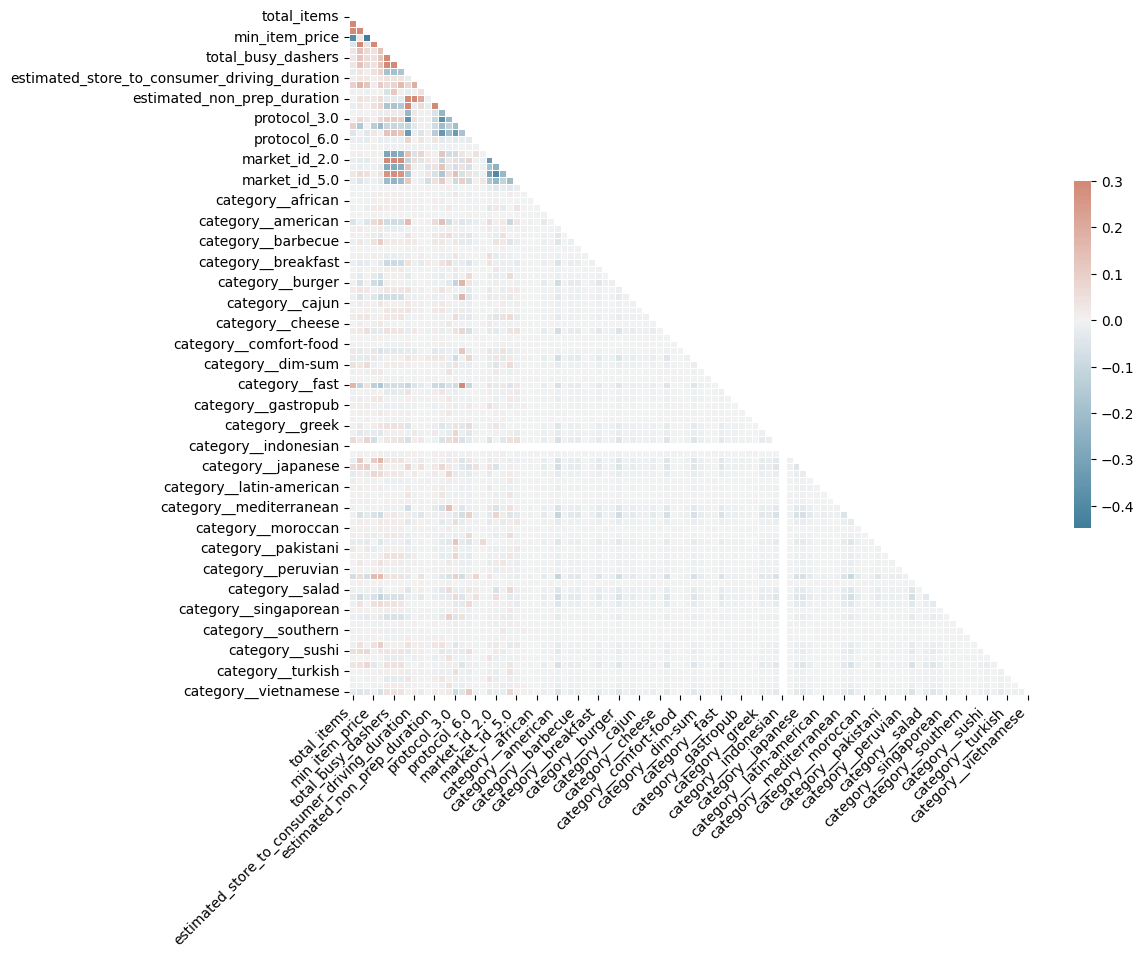

In [19]:
corr = train_df.corr()
# a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# the heatmap
sns.heatmap(corr, cmap=cmap, mask=mask, vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [20]:
train_df['category__indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category__indonesian, dtype: float64

In [21]:
train_df.drop(columns=['category__indonesian'], inplace=True)

In [22]:
def redundant_pairs(df):
    drop_pairs=set()
    cols=df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            drop_pairs.add((cols[i], cols[j]))
    return drop_pairs

def top_abs_corr(df, n=5):
    au_corr=df.corr().abs().unstack()
    drop_labels=redundant_pairs(df)
    au_corr=au_corr.drop(labels=drop_labels).sort_values(ascending=False)
    return au_corr[0:n]

In [23]:
marketid_dummies

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
197423,1.0,0.0,0.0,0.0,0.0,0.0
197424,1.0,0.0,0.0,0.0,0.0,0.0
197425,1.0,0.0,0.0,0.0,0.0,0.0
197426,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print("top 20 absolute corelation")
print(top_abs_corr(train_df, 20))

top 20 absolute corelation
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                protocol_1.0                   0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
protocol_4.0                                  category__fast                 0.489946
num_distinct_items         

In [25]:
train_df.drop(columns=['total_onshift_dashers',
       'estimated_non_prep_duration','total_busy_dashers', 'market_id_1.0','market_id_2.0','market_id_3.0','market_id_4.0','market_id_5.0','market_id_6.0'], inplace=True)

In [26]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dasher_ratio,...,category__southern,category__spanish,category__steak,category__sushi,category__tapas,category__thai,category__turkish,category__vegan,category__vegetarian,category__vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print("top 20 absolute corelation")
print(top_abs_corr(train_df, 20))

top 20 absolute corelation
estimated_order_place_duration  protocol_1.0          0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
protocol_4.0                    category__fast        0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
protocol_1.0                    protocol_3.0          0.373581
estimated_order_place_duration  protocol_3.0          0.364170
protocol_1.0                    protocol_5.0          0.342345
estimated_order_place_duration  protocol_5.0          0.333291
protocol_3.0                    protocol_5.0          0.332533
protocol_1.0                    protocol_2.0          0.226903
estimated_order_place_durati

In [28]:
order_protocol_dummies.columns

Index(['protocol_1.0', 'protocol_2.0', 'protocol_3.0', 'protocol_4.0',
       'protocol_5.0', 'protocol_6.0', 'protocol_7.0'],
      dtype='object')

In [29]:
train_df.drop(columns=['protocol_1.0', 'protocol_2.0', 'protocol_3.0', 'protocol_4.0',
       'protocol_5.0', 'protocol_6.0', 'protocol_7.0'], inplace=True)

In [30]:
print("top 20 absolute corelation")
print(top_abs_corr(train_df, 20))

top 20 absolute corelation
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category__fast                    0.1

In [31]:
train_df['%_distinct_items_total']= train_df['num_distinct_items']/ train_df['total_items']
train_df['avg_price_per_item']=train_df['subtotal']/train_df['total_items']
train_df.drop(columns=['num_distinct_items','subtotal'], inplace=True)

In [32]:
print("top 20 absolute corelation")
print(top_abs_corr(train_df, 20))

top 20 absolute corelation
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   %_distinct_items_total            0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
%_distinct_items_total                        avg_price_per_item                0.226711
category__pizza                               avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                %_distinct_items_total            0.178021
category__fast                                avg_price_per_item                0.1

In [33]:
train_df['price_range']=train_df['max_item_price']-train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

In [34]:
print("top 20 absolute corelation")
print(top_abs_corr(train_df, 20))

top 20 absolute corelation
total_items                                   %_distinct_items_total            0.445751
                                              price_range                       0.333304
                                              avg_price_per_item                0.310759
%_distinct_items_total                        avg_price_per_item                0.226711
category__pizza                               avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category__fast                                avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category__fast                    0.170988
category__italian                             avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.1

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [36]:
def compute_vif(features):
    vif_data=pd.DataFrame()
    vif_data['feature']=features
    vif_data['VIF']=[variance_inflation_factor(train_df[features].values, i)
                    for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True) 

In [37]:
features=train_df.drop(columns=['actual_total_delivery_duration']).columns.to_list()
vif_data=compute_vif(features)
vif_data

,feature,VIF
0,category__alcohol-plus-food,1.000373
1,category__chocolate,1.000508
2,category__belgian,1.000771
3,category__russian,1.003245
4,category__african,1.003825
...,...,...
76,busy_dasher_ratio,6.369577
77,category__american,7.033606
78,estimated_store_to_consumer_driving_duration,7.210893
79,estimated_order_place_duration,13.470942


In [38]:
multicollinearity=True
while multicollinearity:
    highest_vif_feature=vif_data['feature'].values.tolist()[-1]
    print('removing ', highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data=compute_vif(features)
    multicollinearity=False if len(vif_data[vif_data.VIF>20]) == 0 else True
    
selected_features=vif_data['feature'].values.tolist()
vif_data

removing  %_distinct_items_total


,feature,VIF
0,category__alcohol-plus-food,1.000224
1,category__chocolate,1.000377
2,category__belgian,1.000472
3,category__russian,1.002037
4,category__gluten-free,1.002381
...,...,...
75,category__american,4.505930
76,avg_price_per_item,5.958989
77,busy_dasher_ratio,6.357856
78,estimated_store_to_consumer_driving_duration,7.192701


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X=train_df[selected_features]
y=train_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

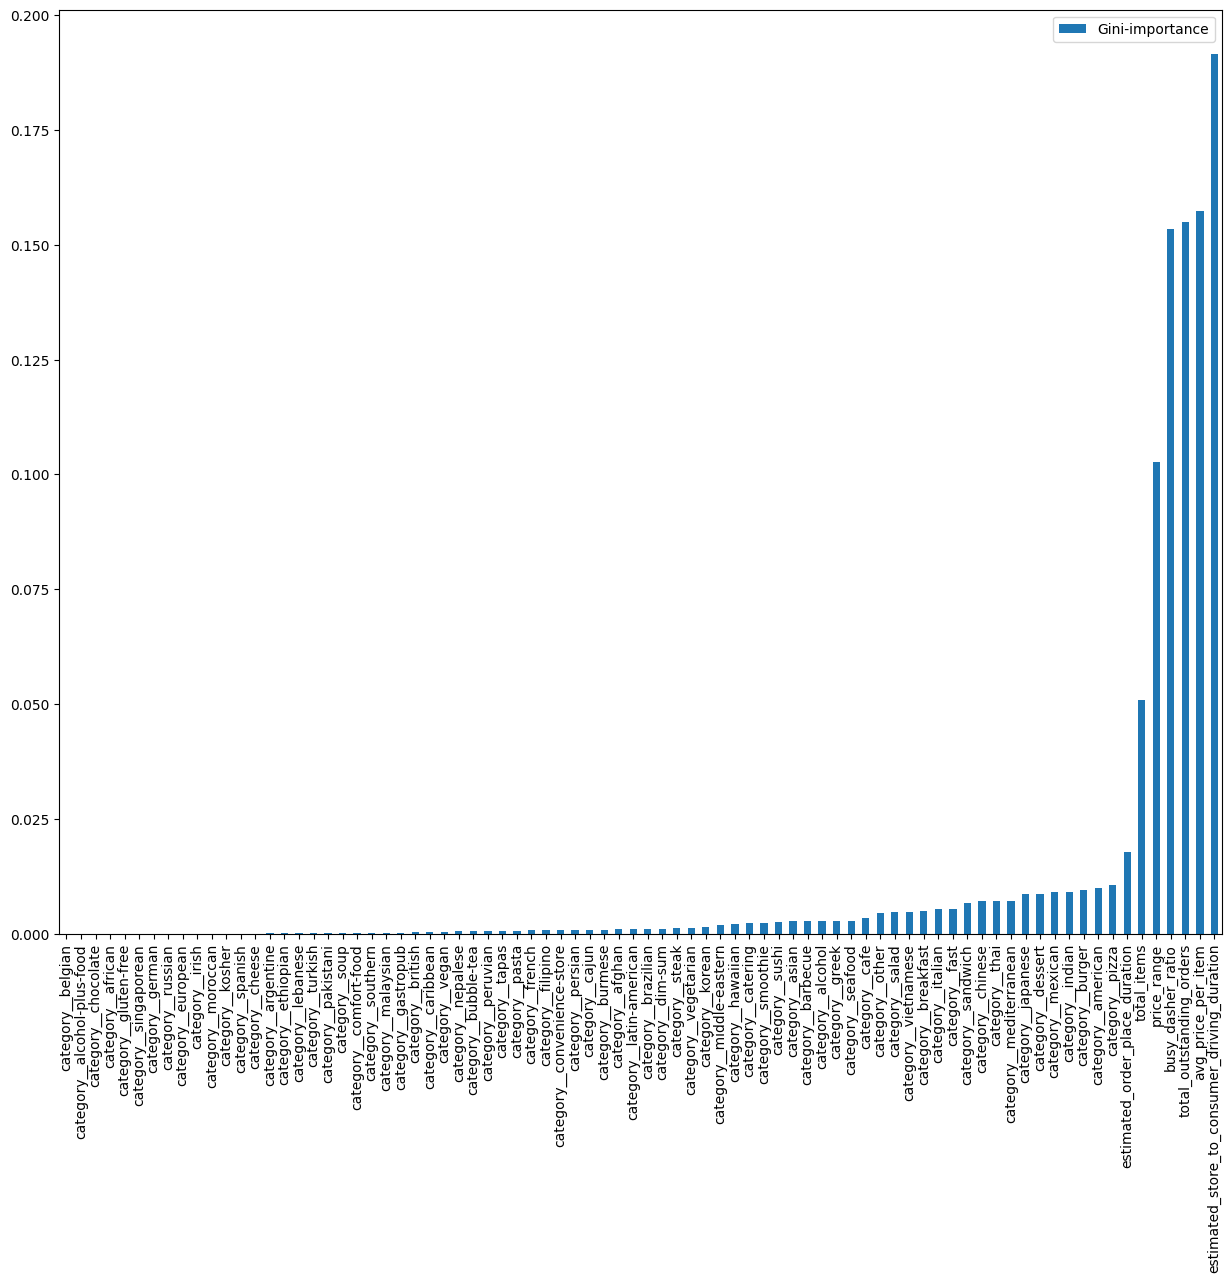

In [40]:
feature_names=[f'feature {i}' for i in range(X.shape[1])]
forest=RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats={}
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature]= importance
importances=pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15, 12))
plt.show()

In [41]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category__middle-eastern',
 'category__hawaiian',
 'category__catering',
 'category__smoothie',
 'category__sushi',
 'category__asian',
 'category__barbecue',
 'category__alcohol',
 'category__greek',
 'category__seafood',
 'category__cafe',
 'category__other',
 'category__salad',
 'category__vietnamese',
 'category__breakfast',
 'category__italian',
 'category__fast',
 'category__sandwich',
 'category__chinese',
 'category__thai',
 'category__mediterranean',
 'category__japanese',
 'category__dessert',
 'category__mexican',
 'category__indian',
 'category__burger',
 'category__american',
 'category__pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range',
 'busy_dasher_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

/var/folders/bp/z3wm8_z13wv97gdjqz3crkc80000gn/T/ipykernel_4913/2248331205.py:9: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


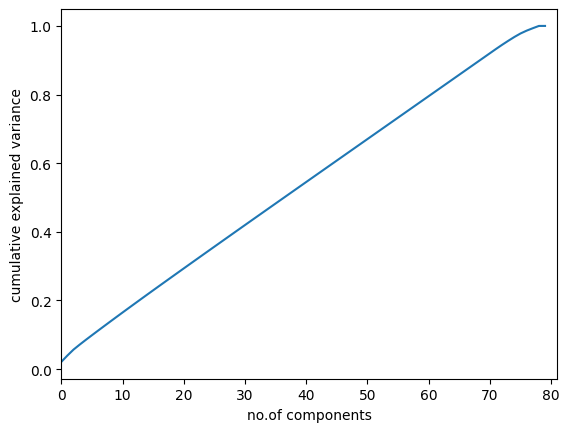

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_train=X_train.values
X_train=np.asarray(X_train)

X_std=StandardScaler().fit_transform(X_train)
pca=PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('no.of components')
plt.ylabel('cumulative explained variance')
plt.show()


In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [44]:
def scale(scaler, X, y):
    X_scaler=scaler
    X_scaler.fit(X=X, y=y)
    X_scaled=X_scaler.transform(X)
    y_scaler=scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled=y_scaler.transform(y.values.reshape(-1,1))
    return X_scaled, y_scaled, X_scaler, y_scaler

In [45]:
X_scaled, y_scaled, X_scaler, y_scaler =scale(MinMaxScaler(), X, y)

X_train_scaled,  X_test_scaled, y_train_scaled, y_test_scaled=train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [46]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict=scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse_error=mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("error="'{}'.format(rmse_error)+" in "+model_name)
    return rmse_error, y_predict

In [47]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train, y_train)
    y_predict=model.predict(X_train)
    train_error=mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error=mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in "+model_name)
        print("Test error = "'{}'.format(test_error)+" in "+model_name)
    trained_model=model
    
    return trained_model, y_predict, train_error, test_error

In [48]:
pred_dict={
    "regression_model":[],
    "feature_set":[],
    "scaler_name":[],
    "RMSE":[]
}

regression_models={
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor()
}

feature_sets ={
    "full_dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by="Gini-importance")[-40:].index.to_list(),
    "Selected_features_20": importances.sort_values(by="Gini-importance")[-20:].index.to_list(),
    "Selected_features_10": importances.sort_values(by="Gini-importance")[-10:].index.to_list()
}

scalers = {
    "Standard Scaler": StandardScaler(),
    "MinMax Scaler": MinMaxScaler(),
    "NotScale": None
}

for feature_set_name, feature_set in feature_sets.items():
    for scaler_name, scaler in scalers.items():
        print(f"------scaled with {scaler_name}------included columns are {feature_set_name}")
        print("")
        X = train_df[feature_set]
        y = train_df['actual_total_delivery_duration']
        
        if scaler_name == 'NotScale':
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            for model_name, model in regression_models.items():
                make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True)
        else:
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scaler, X, y)
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42)
            for model_name, model in regression_models.items():
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0],
                                                            X_test_scaled, y_test_scaled[:, 0], model, model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)

------scaled with Standard Scaler------included columns are full_dataset

Train error = 0.767963171005249 in Ridge
Test error = 1.4719302654266357 in Ridge
error=2053.69873046875 in Ridge
Train error = 0.7653021361303404 in DecisionTree
Test error = 1.4744739559914226 in DecisionTree
error=2057.2476687088733 in DecisionTree
Train error = 0.28612494247215137 in RandomForest
Test error = 1.4677010659034901 in RandomForest
error=2047.7978491618828 in RandomForest
Train error = 0.6924042105674744 in XGBoost
Test error = 1.4594244956970215 in XGBoost
error=2036.2498779296875 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [Info] Start training from score -0.002379
Trai

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.4253e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 396.6344867613689 in RandomForest
Test error = 2049.7825093478873 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [Info] Start training from score 2851.342096
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.8280029296875 in MLP
Test error = 2049.017822265625 in MLP
------scaled with Standard Scaler------included columns are selected_features_40

Train error = 0.7685800194740295 in Ridge
Test error = 1.47214937210083 in Ridge
error=2054.00439453125 in Ridge
Train error = 0.7653050277966773 in DecisionTree
Test error = 1.4739590156893994 in DecisionTree
error=2056.5292024696128 in DecisionTree
Train error = 0.2856548320328106 in RandomForest
Test error = 1.466958156061624 in RandomForest
error=2046.76131024508 in RandomForest
Train error = 0.6926604509353638 in XGBoost
Test error = 1.4588536024093628 in XGBoost
error=2035.453369140625 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 141656, number

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 396.3738119782914 in RandomForest
Test error = 2048.2382925337897 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[LightGBM] [Info] Start training from score 2851.342096
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.1055908203125 in MLP
Test error = 2047.30419921875 in MLP
------scaled with Standard Scaler------included columns are Selected_features_20

Train error = 0.770122230052948 in Ridge
Test error = 1.4731249809265137 in Ridge
error=2055.36572265625 in Ridge
Train error = 0.7662722630951128 in DecisionTree
Test error = 1.4725837048094073 in DecisionTree
error=2054.610311207463 in DecisionTree
Train error = 0.2864932255572912 in RandomForest
Test error = 1.4686778586382527 in RandomForest
error=2049.1607111613384 in RandomForest
Train error = 0.6905712485313416 in XGBoost
Test error = 1.4604161977767944 in XGBoost
error=2037.6336669921875 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 141656, num

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.43857e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 398.7928112463123 in RandomForest
Test error = 2050.0768072661954 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 20
[LightGBM] [Info] Start training from score 2851.342096
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.593994140625 in MLP
Test error = 2048.50927734375 in MLP
------scaled with Standard Scaler------included columns are Selected_features_10

Train error = 0.7717142105102539 in Ridge
Test error = 1.4739872217178345 in Ridge
error=2056.568359375 in Ridge
Train error = 0.7663420076820632 in DecisionTree
Test error = 1.4725742906448305 in DecisionTree
error=2054.5971761770547 in DecisionTree
Train error = 0.28838378145358157 in RandomForest
Test error = 1.4708854128312077 in RandomForest
error=2052.240783072941 in RandomForest
Train error = 0.6992177963256836 in XGBoost
Test error = 1.4623059034347534 in XGBoost
error=2040.27001953125 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 141656, number

In [49]:
pred_df=pd.DataFrame(pred_dict)

In [50]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,Standard Scaler,2053.698730
1,DecisionTree,full_dataset,Standard Scaler,2057.247669
2,RandomForest,full_dataset,Standard Scaler,2047.797849
3,XGBoost,full_dataset,Standard Scaler,2036.249878
4,LGBM,full_dataset,Standard Scaler,2033.435581
5,MLP,full_dataset,Standard Scaler,2036.578003
6,Ridge,full_dataset,MinMax Scaler,2053.962891
7,DecisionTree,full_dataset,MinMax Scaler,2057.247669
8,RandomForest,full_dataset,MinMax Scaler,2048.902226
9,XGBoost,full_dataset,MinMax Scaler,2035.351318


<Axes: >

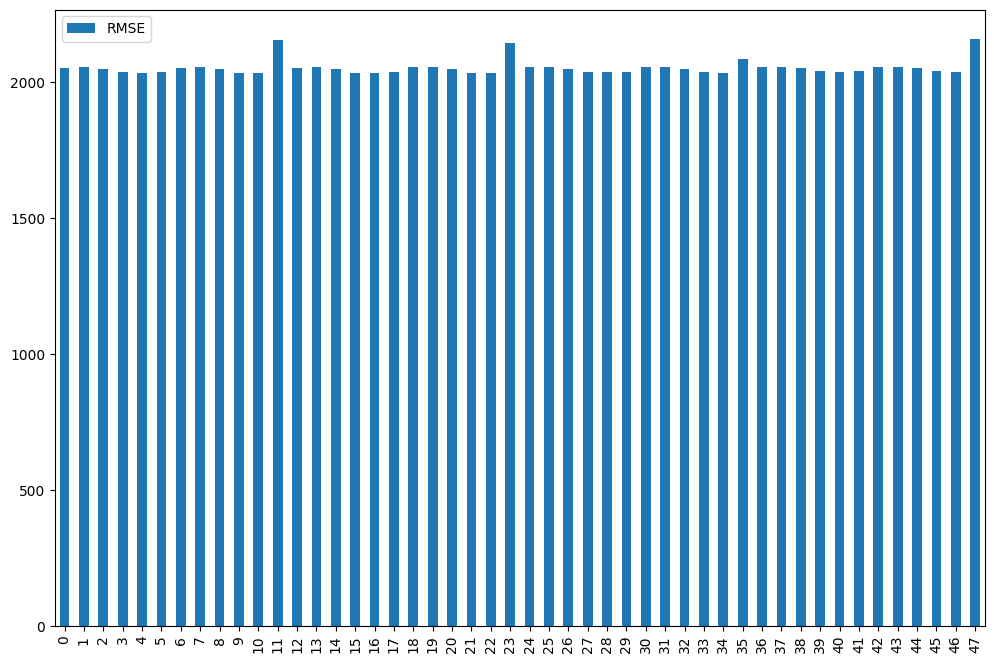

In [51]:
pred_df.plot(kind='bar', figsize=(12,8))

In [52]:
train_df['prep_time']= train_df['actual_total_delivery_duration']-train_df['estimated_store_to_consumer_driving_duration']-train_df['estimated_order_place_duration']

In [53]:
scalers={"StandardScaler":StandardScaler()}
feature_sets={"selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist()}

In [54]:
for feature_set_name in feature_sets.keys():
    feature_set=feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"------scaled with {scaler_name}------included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X=train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration'])
            y=train_df['prep_time']
            
            X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=42)
            train_indices=X_train.index
            test_indices=X_test.index
            
            X_scaled, y_scaled, X_scaler, y_scaler=scale(scalers[scaler_name], X, y)
            
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled =train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0],
                                                            X_test_scaled, y_test_scaled[:, 0], model, model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

------scaled with StandardScaler------included columns are selected_features_40

Train error = 0.7584515810012817 in Ridge
Test error = 1.492159366607666 in Ridge
error=2038.47900390625 in Ridge
Train error = 0.7584445476531982 in DecisionTree
Test error = 1.4923001527786255 in DecisionTree
error=2038.6712646484375 in DecisionTree
Train error = 0.7575686573982239 in RandomForest
Test error = 1.4918956756591797 in RandomForest
error=2038.11865234375 in RandomForest
Train error = 0.7581849694252014 in XGBoost
Test error = 1.4922648668289185 in XGBoost
error=2038.6229248046875 in XGBoost
Train error = 0.757742166519165 in LGBM
Test error = 1.492110252380371 in LGBM
error=2038.4119873046875 in LGBM
Train error = 0.7590750455856323 in MLP
Test error = 1.4923757314682007 in MLP
error=2038.7745361328125 in MLP


In [55]:
pred_values_dict={"actual_total_delivery_duration": train_df['actual_total_delivery_duration'][test_indices].values.tolist(),
                 "prep_duration_prediction":y_predict[:,0].tolist(),
                 "estimated_store_to_consumer_driving_duration":train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
                 "estimated_order_place_duration":train_df["estimated_order_place_duration"][test_indices].values.tolist()
                }

In [56]:
values_df=pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1865.587158,380.0,251.0
1,1839.0,1317.211914,747.0,446.0
2,1927.0,2156.658691,543.0,251.0
3,2657.0,1220.201904,445.0,251.0
4,3596.0,2024.432251,691.0,446.0
...,...,...,...,...
35409,9557.0,2600.445068,768.0,446.0
35410,1864.0,2333.233398,324.0,446.0
35411,2674.0,1778.195190,791.0,251.0
35412,2234.0,1781.182251,687.0,251.0


In [57]:
values_df["sum_total_delivery_duration"]=values_df["estimated_store_to_consumer_driving_duration"]+values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1865.587158,380.0,251.0,631.0
1,1839.0,1317.211914,747.0,446.0,1193.0
2,1927.0,2156.658691,543.0,251.0,794.0
3,2657.0,1220.201904,445.0,251.0,696.0
4,3596.0,2024.432251,691.0,446.0,1137.0
...,...,...,...,...,...
35409,9557.0,2600.445068,768.0,446.0,1214.0
35410,1864.0,2333.233398,324.0,446.0,770.0
35411,2674.0,1778.195190,791.0,251.0,1042.0
35412,2234.0,1781.182251,687.0,251.0,938.0


In [58]:
mean_squared_error(values_df["actual_total_delivery_duration"],values_df["sum_total_delivery_duration"],squared=False)

2895.18899743313

In [59]:
X=values_df[["prep_duration_prediction","estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y=values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
regression_models={
    "LinearReg": linear_model.LinearRegression(),
    "Ridge":linear_model.Ridge(),
    "DecisionTree":tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest":RandomForestRegressor(),
    "XGBoost":XGBRegressor(),
    "LGBM":LGBMRegressor(),
    "MLP": MLPRegressor()
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of ", model_name, mean_squared_error(y_test, y_predict, squared=False))

RMSE of  LinearReg 993.0859811049747
RMSE of  Ridge 993.0859811092039
RMSE of  DecisionTree 1004.9510825023998
RMSE of  RandomForest 1195.81172375899
RMSE of  XGBoost 1168.1352616813986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 3
[LightGBM] [Info] Start training from score 2869.174261
RMSE of  LGBM 1122.9166177164846
RMSE of  MLP 993.0096248224659


In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

In [62]:
def create_model(feature_set_size):
    model=Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='sgd', loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [63]:
print(f"----scaled with {scaler_name}------included columns are {feature_set_name}")
print("")
model_name='ANN'
scaler_name="StandardScaler"
X=values_df[["prep_duration_prediction","estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y=values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler=scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled =train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:", X_train_scaled.shape[1])
model=create_model(feature_set_size=X_train_scaled.shape[1])
history=model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred=model.predict(X_test_scaled)
rmse_error=rmse_with_inv_transform(y_scaler, y_test,y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

----scaled with StandardScaler------included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 0s 278us/step - loss: 1.1448 - root_mean_squared_error: 1.0699
Epoch 2/100
443/443 [==============================] - 0s 268us/step - loss: 1.1235 - root_mean_squared_error: 1.0600
Epoch 3/100
443/443 [==============================] - 0s 265us/step - loss: 1.1218 - root_mean_squared_error: 1.0591
Epoch 4/100
443/443 [==============================] - 0s 270us/step - loss: 1.1218 - root_mean_squared_error: 1.0591
Epoch 5/100
443/443 [==============================] - 0s 262us/step - loss: 1.1214 - root_mean_squared_error: 1.0590
Epoch 6/100
443/443 [==============================] - 0s 271us/step - loss: 1.1214 - root_mean_squared_error: 1.0590
Epoch 7/100
443/443 [==============================] - 0s 265us/step - loss: 1.1210 - root_mean_squared_error: 1.0588
Epoch 8/100
443/443 [==============================] - 0s 264us/step - loss

443/443 [==============================] - 0s 305us/step - loss: 1.1194 - root_mean_squared_error: 1.0580
Epoch 70/100
443/443 [==============================] - 0s 271us/step - loss: 1.1194 - root_mean_squared_error: 1.0580
Epoch 71/100
443/443 [==============================] - 0s 282us/step - loss: 1.1198 - root_mean_squared_error: 1.0582
Epoch 72/100
443/443 [==============================] - 0s 275us/step - loss: 1.1191 - root_mean_squared_error: 1.0579
Epoch 73/100
443/443 [==============================] - 0s 272us/step - loss: 1.1201 - root_mean_squared_error: 1.0583
Epoch 74/100
443/443 [==============================] - 0s 291us/step - loss: 1.1194 - root_mean_squared_error: 1.0580
Epoch 75/100
443/443 [==============================] - 0s 286us/step - loss: 1.1193 - root_mean_squared_error: 1.0579
Epoch 76/100
443/443 [==============================] - 0s 395us/step - loss: 1.1192 - root_mean_squared_error: 1.0579
Epoch 77/100
443/443 [==============================] - 0s 34

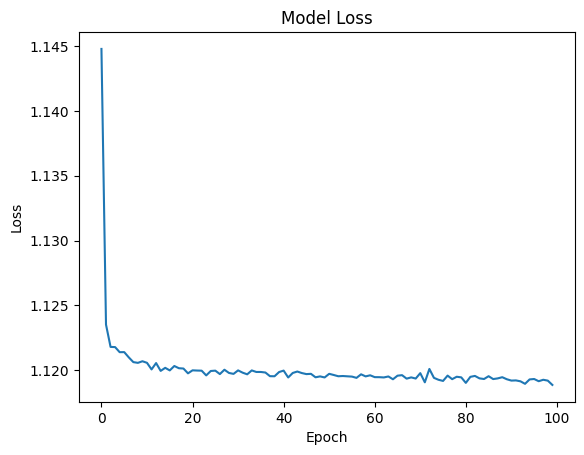

In [64]:
plt.plot(history.history['loss'])
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [65]:
#solution is Using LGBM and Linear Regresssion on top